# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [125]:
! git clone https://www.github.com/DS3001/assignment4

fatal: destination path 'assignment4' already exists and is not an empty directory.


**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.

<Axes: >

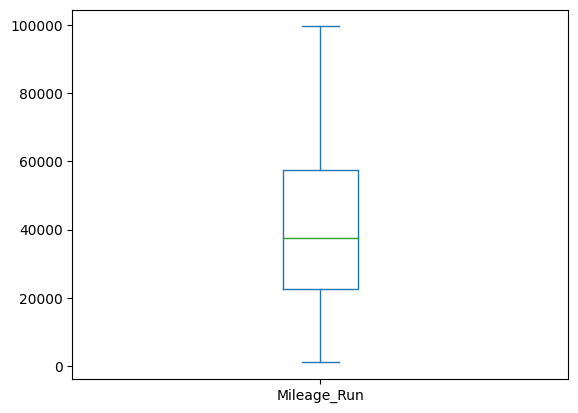

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./assignment4/data/cars_hw.csv', low_memory=False)

plt.figure()
df['Mileage_Run'].plot.box()
# No outliers seen

<Axes: >

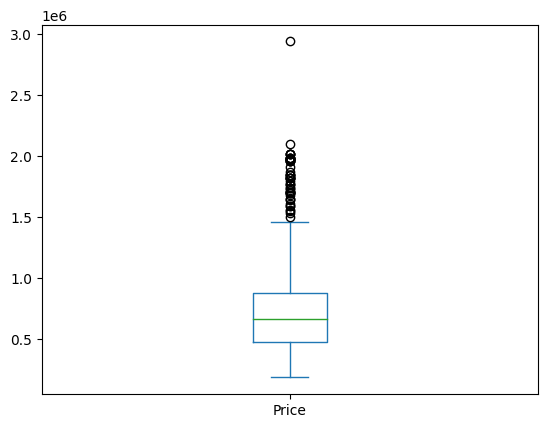

In [127]:
plt.figure()
df['Price'].plot.box()
# Outliers -> requires arcsinh transformation

<Axes: >

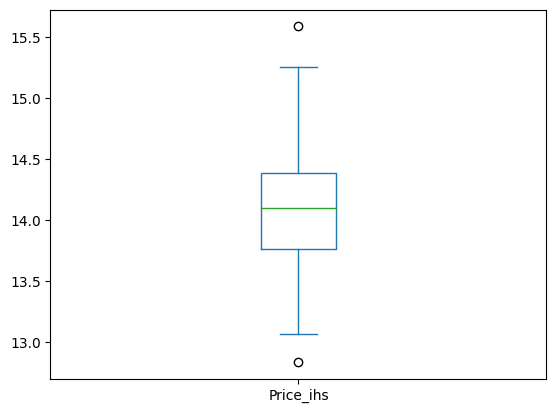

In [128]:
df['Price_ihs'] = np.arcsinh(df['Price'])
plt.figure()
df['Price_ihs'].plot.box()
# Outliers above 15.5 and below 13

<Axes: >

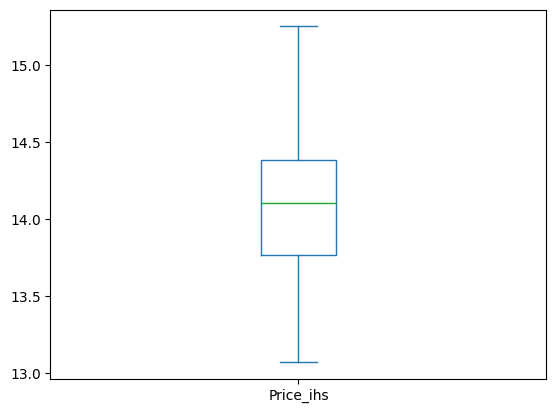

In [129]:
df = df.loc[df['Price_ihs'] < 15.5,:]
df = df.loc[df['Price_ihs'] > 13, :]
df['Price_ihs'].plot.box()

  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?

count    9.740000e+02
mean     7.393285e+05
std      3.604336e+05
min      2.370000e+05
25%      4.762500e+05
50%      6.665000e+05
75%      8.827500e+05
max      2.100000e+06
Name: Price, dtype: float64
count    974.000000
mean      14.103958
std        0.446380
min       13.068963
25%       13.766845
50%       14.102942
75%       14.383944
max       15.250595
Name: Price_ihs, dtype: float64


<Axes: ylabel='Density'>

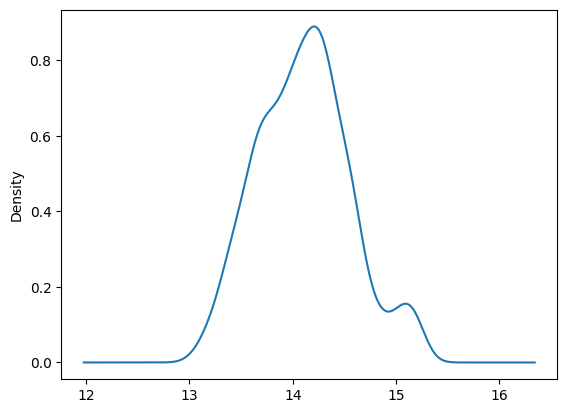

In [130]:
var = 'Price_ihs'
print(df['Price'].describe())
print(df[var].describe())
df[var].plot.density()

              Price_ihs                                                        \
                  count       mean       std        min        25%        50%   
Make                                                                            
Chevrolet           6.0  13.613042  0.480975  13.188151  13.261539  13.445433   
Datsun              3.0  13.269194  0.036311  13.232114  13.251449  13.270783   
Ford               52.0  14.161427  0.210895  13.270783  14.054527  14.162640   
Honda              73.0  14.229465  0.336972  13.356645  13.965653  14.266586   
Hyundai           305.0  14.061658  0.398781  13.114331  13.785051  14.059241   
Jeep                4.0  14.909738  0.105084  14.763300  14.876417  14.933413   
Kia                 8.0  14.985324  0.076877  14.822738  14.965389  14.996253   
MG Motors          35.0  15.132199  0.066263  14.971763  15.088892  15.122762   
Mahindra           18.0  14.592100  0.159906  14.280502  14.544955  14.598828   
Maruti Suzuki     293.0  13.

<Axes: ylabel='Density'>

<Figure size 640x480 with 0 Axes>

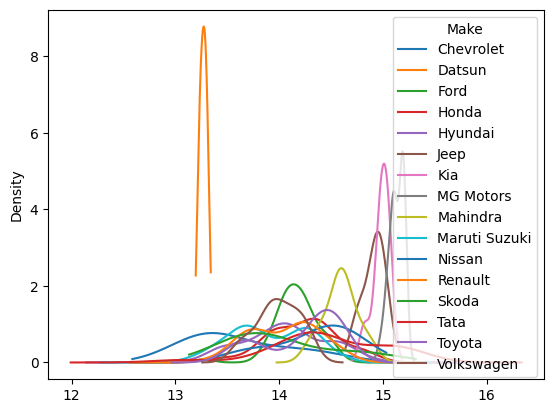

In [131]:
group_by = 'Make'
print(df.loc[:,[group_by,var]].groupby(group_by).describe())
plt.figure()
df_wide = df.pivot(columns=group_by, values=var)
df_wide.plot.density()

**It appears that MG Motors is the most expensive car brand, followed by Kia and Jeep. In general prices tend to lie around $700,000.**

  3. Split the data into an 80% training set and a 20% testing set.

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

categorical_vars = ['Color', 'Body_Type', 'Make','Fuel_Type', 'Transmission', 'Transmission_Type']
numerical_vars = ['Mileage_Run', 'Seating_Capacity', 'Make_Year']

temp = df.loc[:, categorical_vars]
df_encoded = pd.get_dummies(temp, columns=categorical_vars)

X = df.loc[:, numerical_vars]

def maxmin(x):
  x = (x-min(x))/(max(x)-min(x))
  return x
X = X.apply(maxmin)
X=pd.concat([X, df_encoded], axis=1)

y = df['Price_ihs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=100)

  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?

In [133]:
from sklearn.linear_model import LinearRegression
X_train_numeric = X_train.loc[:, numerical_vars]
reg_numerical = LinearRegression().fit(X_train_numeric, y_train)
X_test_numeric = X_test.loc[:,numerical_vars]
print('R2: ', reg_numerical.score(X_test_numeric, y_test))
y_hat = reg_numerical.predict(X_test_numeric)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )

R2:  0.3047529736488599
RMSE:  0.35406910846729667


In [134]:
ohe_vars = list(df_encoded.columns)
X_train_categorical = X_train.loc[:, ohe_vars]
reg_categorical = LinearRegression().fit(X_train_categorical, y_train)
X_test_categorical = X_test.loc[:, ohe_vars]
print('R2: ', reg_categorical.score(X_test_categorical, y_test))
y_hat = reg_categorical.predict(X_test_categorical)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )

R2:  0.6490458385186233
RMSE:  0.25156120459593617


**The model for the categorical variables performs better on the test set than the model for the numerical variables does.**

In [135]:
reg_joint = LinearRegression().fit(X_train, y_train)
print('R2: ', reg_joint.score(X_test, y_test))
y_hat_joint = reg_joint.predict(X_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )

R2:  0.8172862535163825
RMSE:  0.25156120459593617


**The joint model performs better than the previous two models. It has an $R^2$ value that is 0.51 greater than the first model and 0.168 greater than the second model. The RMSE value is also lower than the first models RSME by 0.17 and lower than the second models RMSE by 0.07.**

  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?

In [136]:
from sklearn.preprocessing import PolynomialFeatures

expander = PolynomialFeatures(degree=2, include_bias=False)
Z = expander.fit_transform(X_train_numeric)
names = expander.get_feature_names_out()
Z_train = pd.DataFrame(data=Z, columns=names)

expander = PolynomialFeatures(degree=2, include_bias=False)
Z = expander.fit_transform(X_test_numeric)
names = expander.get_feature_names_out()
Z_test = pd.DataFrame(data=Z, columns=names)

reg_numerical_expanded = LinearRegression().fit(Z_train, y_train)
print('R2: ', reg_numerical_expanded.score(Z_test, y_test))
y_hat = reg_numerical_expanded.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )

R2:  0.3566002069658112
RMSE:  0.3406112011795531


In [137]:
expander = PolynomialFeatures(degree=2, include_bias=False)
Z = expander.fit_transform(X_train_categorical)
names = expander.get_feature_names_out()
Z_train = pd.DataFrame(data=Z, columns=names)

expander = PolynomialFeatures(degree=2, include_bias=False)
Z = expander.fit_transform(X_test_categorical)
names = expander.get_feature_names_out()
Z_test = pd.DataFrame(data=Z, columns=names)

reg_categorical_expanded = LinearRegression().fit(Z_train, y_train)
print('R2: ', reg_categorical_expanded.score(Z_test, y_test))
y_hat = reg_categorical_expanded.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )

R2:  -1.253845875240557e+24
RMSE:  475489077564.4206


In [138]:
expander = PolynomialFeatures(degree=2, include_bias=False)
Z = expander.fit_transform(X_train)
names = expander.get_feature_names_out()
Z_train = pd.DataFrame(data=Z, columns=names)

expander = PolynomialFeatures(degree=2, include_bias=False)
Z = expander.fit_transform(X_test)
names = expander.get_feature_names_out()
Z_test = pd.DataFrame(data=Z, columns=names)

reg_joint_expanded = LinearRegression().fit(Z_train, y_train)
print('R2: ', reg_joint_expanded.score(Z_test, y_test))
y_hat = reg_joint_expanded.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )

R2:  -7.393535146836673e+18
RMSE:  1154634522.3424175


**When the set of numerical variables is expanded, it results in a better $R^2$ and value than the previous linear model on just numerical variables. When just the categorical variables or the joint dataframe with both categorical and numerical variables are expanded, it results in a negative $R^2$ value. As the degree of expansion is increased the $R^2$ values decreases and the RMSE value increases. For the first model where just the numerical variables are expanded and used, $R^2$ goes negative when the degree expansion is greater than or equal to 5. The best model is the one with just the expanded numerical variables which has an $R^2$ value of 0.3566002069658112 and RMSE value of 0.3406112011795531. This $R^2$ is 0.46 lower than the $R^2$ of the best model in question 4 and the RMSE is 0.159 higher than the previous best.**

  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

Text(0.5, 1.0, 'True vs Predicted Values')

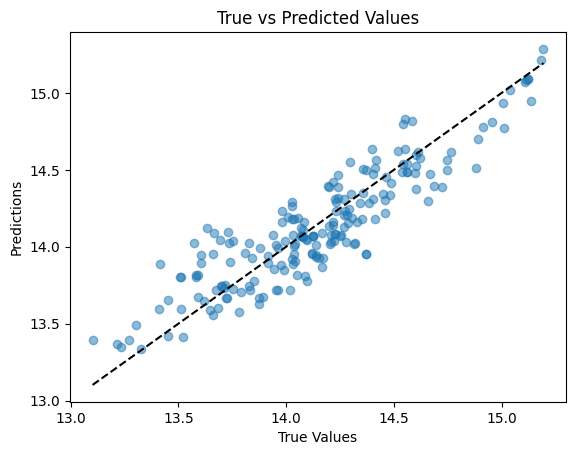

In [139]:
plt.figure()
plt.scatter(y_test, y_hat_joint, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')

**Yes, the predicted values tend to line up against the diagonal.**

Text(0.5, 1.0, 'Kernel Density of Residuals')

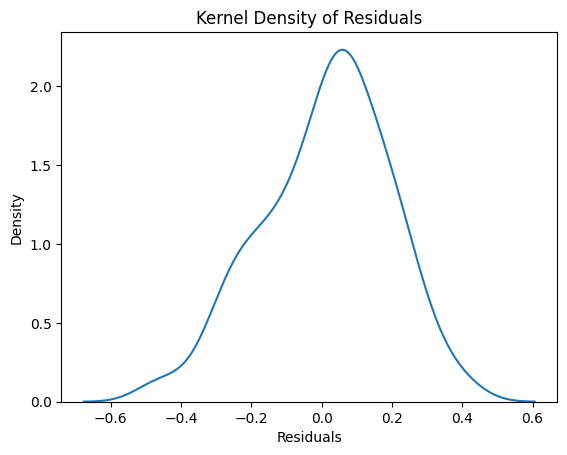

In [140]:
import seaborn as sns

residuals = y_test - y_hat_joint
plt.figure()
sns.kdeplot(residuals)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Kernel Density of Residuals')

**Yes, the residuals for the test data are roughly bell-shaped around zero. This indicates that this is a strong model. I had already seen during question 4 that this model has a high $R^2$ and low RMSE value. The predicted values are also lined up against the diagonal and the redisudlas are normally distrubyted and centered around zero. These are all indications of a strong model.**

  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?

In [141]:
from sklearn import tree

max_depths = range(1,20)
best_depth = 0
best_r2 = -float('inf')
best_rmse = float('inf')

for D in max_depths:
  cart = tree.DecisionTreeRegressor(max_depth=D)
  cart.fit(X_train, y_train)

  y_hat = cart.predict(X_test)
  r2 = cart.score(X_test, y_test)
  N = len(y_test)
  rmse = (np.sum( (y_test - y_hat)**2)/N )**.5
  if r2 > best_r2 and rmse < best_rmse:
      best_r2 = r2
      best_rmse = rmse
      best_depth = D

print(f"Best Depth: {best_depth}, Best R2: {best_r2:.4f}, Best RMSE: {best_rmse:.4f}")

Best Depth: 9, Best R2: 0.7491, Best RMSE: 0.2127


  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?

Text(0.5, 1.0, 'True vs Predicted Values')

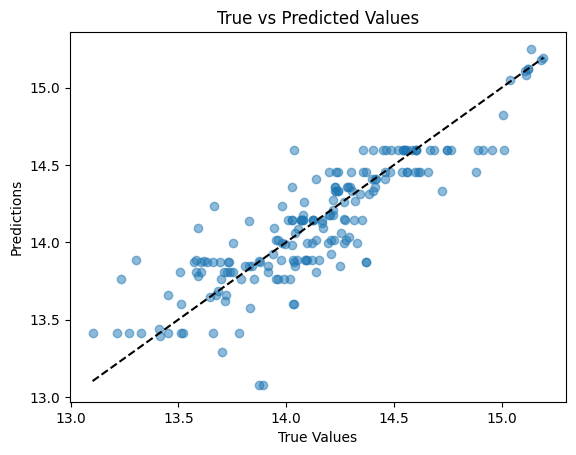

In [142]:
cart = tree.DecisionTreeRegressor(max_depth=9)
cart.fit(X_train, y_train)
y_hat_tree = cart.predict(X_test)
plt.figure()
plt.scatter(y_test, y_hat_tree, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')

Text(0.5, 1.0, 'Kernel Density of Residuals')

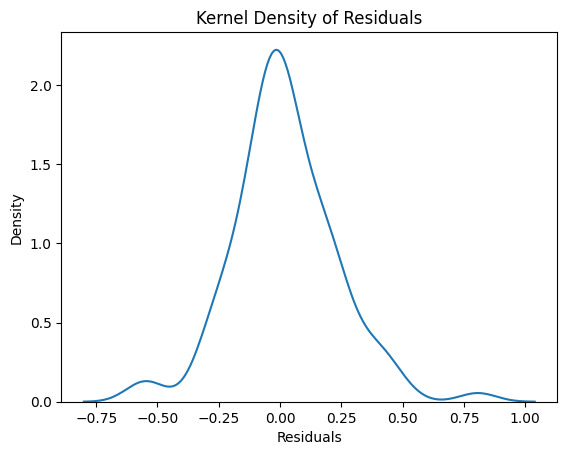

In [143]:
residuals = y_test - y_hat_tree
plt.figure()
sns.kdeplot(residuals)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Kernel Density of Residuals')

**Yes, the residuals for the test data are roughly bell-shaped around zero.**

9. Which model --- linear model or classification and regression tree --- has better performance on the test set?

**For this test set the linear model has a better performance. It has a higher $R^2$ value and lower RMSE value than the best regression tree model.**

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?

In [145]:
df = pd.read_csv('./assignment4/data/contraception_hw.csv', low_memory=False)

print(df['method'].value_counts())
print(pd.crosstab(df['method'],df['numberChildren']))

1    629
3    511
2    333
Name: method, dtype: int64
numberChildren  0    1    2    3   4   5   6   7   8   9   10  11  12  13  16
method                                                                       
1               95  143  114   70  57  44  35  18  29   5   9   6   4   0   0
2                0   46   56   70  62  36  27  19   9   3   2   2   0   1   0
3                2   87  106  119  78  55  30  12   9   8   0   3   0   1   1


**Yes, it appears that those who fall in the 1 category, No Contraception, tend to have more children, but there are some outliers.**

  2. Split the sample into ~80% training data and ~20% testing data.

In [147]:
X = df.drop('method', axis=1)
y = df['method']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.

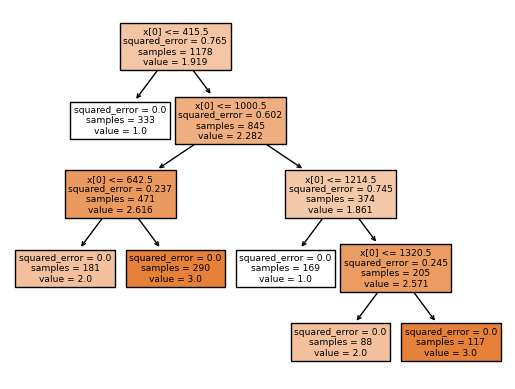

In [148]:
cart = tree.DecisionTreeRegressor()
cart.fit(X_train, y_train)
tree.plot_tree(cart, filled=True)
plt.show()

**The terminal nodes in the decision tree have continuous values which does not make sense in predicting the outcome for contraceptive methods where we would expect discrete categories (1, 2, or 3). Using the regression tree leads to these results because the algorithm assumes that the target variavle is continuous and normally distributed which is problematic for the categorical variable we are trying to predict.**

  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?

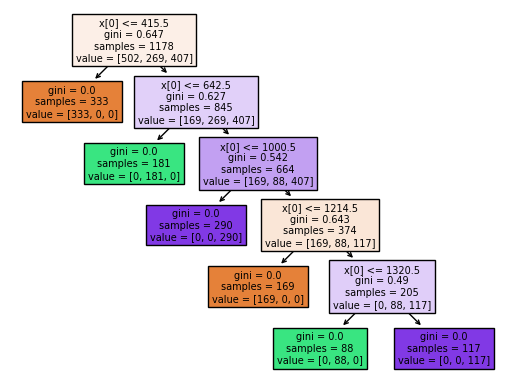

In [149]:
cart = tree.DecisionTreeClassifier()
cart = cart.fit(X_train,  y_train)

plt.figure()
tree.plot_tree(cart, filled=True)
plt.show()

**The classification tree does not use the $R^2$ value like the regression tree does. Instead it uses the Gini impurity as a measure for the quality of a split. This tree also includes distribution of the contraceptive methods among the samples that fall into that node.**

  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.

In [ ]:
y_hat = cart.predict(X_test)

tab = pd.crosstab(np.array(y_hat), np.array(y_test))

tp = tab.iloc[0,0]
tn = tab.iloc[1,1]
fp = tab.iloc[0,1]
fn = tab.iloc[1,0]
tot = tp+tn+fp+fn

acc = (tp+tn)/tot

  6. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?